In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
import sys, os, glob, shutil
import cmocean as cm

from dask.distributed import Client
from tqdm import tqdm

In [3]:
# Load workers:
client = Client(n_workers=14)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42755,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39357,Total threads: 1
Dashboard: /proxy/42011/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:33053,


In [4]:
ds = xr.open_dataset("/g/data/p73/archive/CMIP6/ACCESS-CM2/bj594/history/ocn/ocean_month.nc-20140630").isel(time=0)

# Load 3D flux convergence diagnostic for check:
# # NOTE: The temp_advection diagnostic in the CMIP6 ACCESS-CM2 runs is corrupted and incorrect. 
# It can be reconstructed from the residual of all the other heat budget diagnostics as follows:
bvars3D = ['temp_submeso',
           'temp_vdiffuse_diff_cbt', 'temp_nonlocal_KPP',
           'temp_vdiffuse_sbc','frazil_3d','sw_heat','temp_rivermix',
           'neutral_diffusion_temp','neutral_gm_temp','temp_vdiffuse_k33',
           'mixdownslope_temp','temp_sigma_diff']; # 3D RHS budget terms 
bvars2D = ['sfc_hflux_pme','temp_eta_smooth','pme_river'] # 2D RHS budget terms
temp_advection = ds.temp_tendency.load()
for var in bvars3D:
    temp_advection = temp_advection -  ds[var].load()
for var in bvars2D:
    temp_advection[0,:,:] =  temp_advection[0,:,:] - ds[var].load()

# flux components in Watts (face-integrated heat transports)
Fx = ds["temp_xflux_adv"]
Fy = ds["temp_yflux_adv"]
Fz = ds["temp_zflux_adv"]

# horizontal cell area (m2)
Ah = ds['area_t']

# Compute flux divergences (note - it would be better to use xgcm for this, but the below works)
dFxdx = xr.concat([Fx.isel(xu_ocean=-1),Fx],dim='xu_ocean').diff('xu_ocean').rename({'xu_ocean':'xt_ocean'}).assign_coords(xt_ocean=temp_advection.xt_ocean.values)/Ah # longitude is cylic
dFydy = xr.concat([Fy.isel(yu_ocean=0),Fy],dim='yu_ocean').diff('yu_ocean').rename({'yu_ocean':'yt_ocean'}).assign_coords(yt_ocean=temp_advection.yt_ocean.values)/Ah # Latitude - note that the first element will be wrong, but it's inside Antarctica so doesn't matter
dFzdz = - xr.concat([xr.zeros_like(Fz.isel(sw_ocean=0)),Fz],dim='sw_ocean').diff('sw_ocean').rename({'sw_ocean':'st_ocean'}).assign_coords(st_ocean=temp_advection.st_ocean.values)/Ah # Negative sign here to get divergence

adv_tendency =  - (dFxdx + dFydy + dFzdz)

/jobfs/148168959.gadi-pbs/ipykernel_597046/1345415784.py:1: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset("/g/data/p73/archive/CMIP6/ACCESS-CM2/bj594/history/ocn/ocean_month.nc-20140630").isel(time=0)


Text(0.5, 1.0, 'Difference')

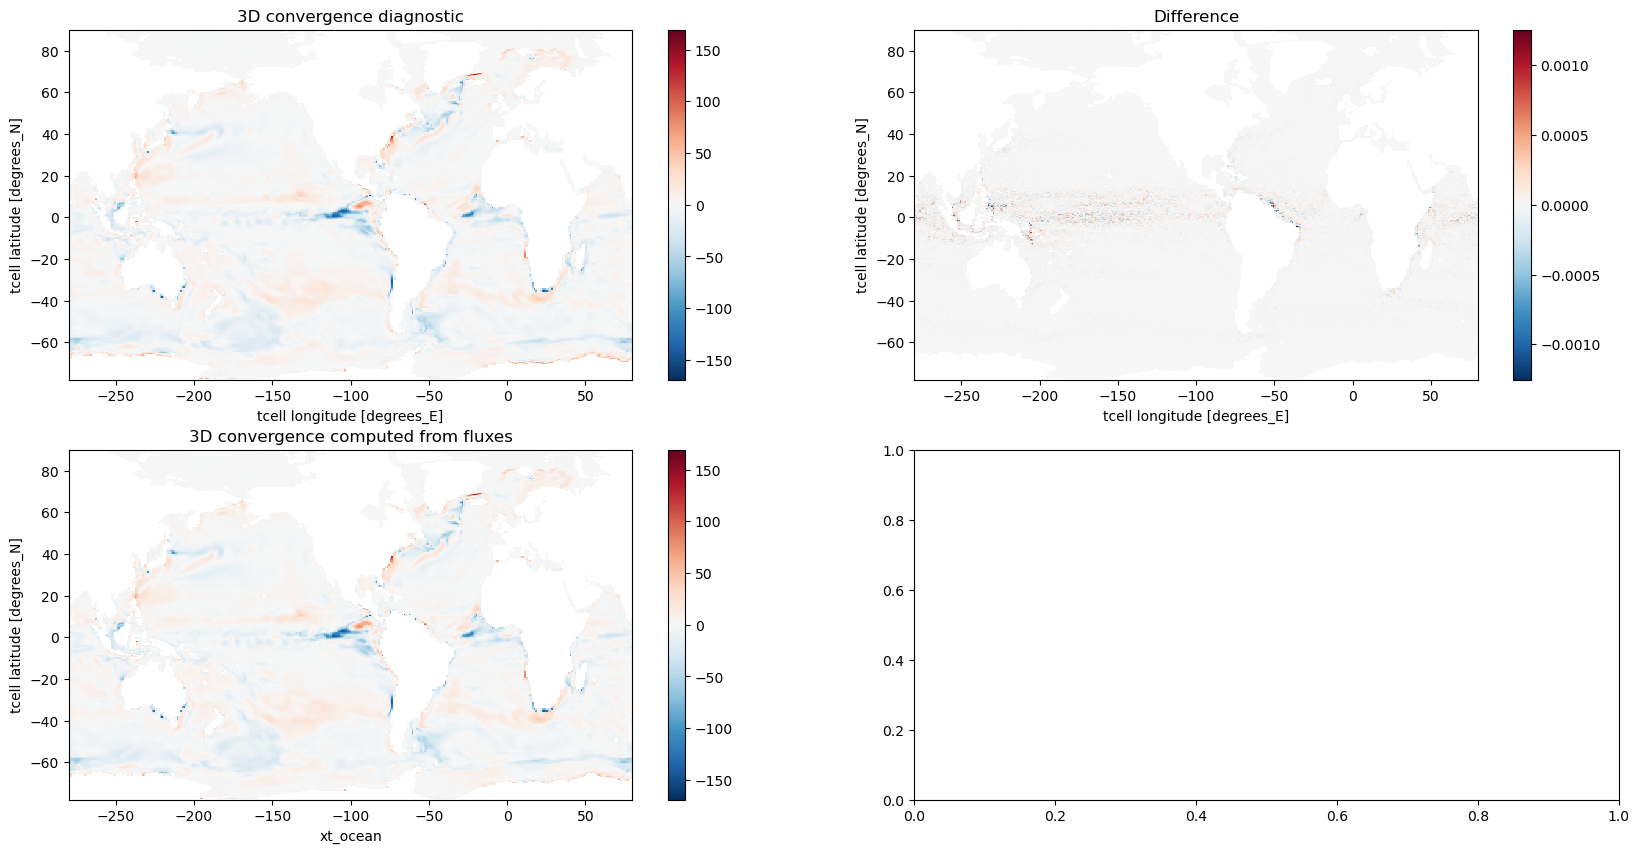

In [6]:
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10))
temp_advection.isel(st_ocean=3).plot(ax=axes[0][0])
adv_tendency.isel(st_ocean=3).plot(ax=axes[1][0])
(temp_advection-adv_tendency).isel(st_ocean=3).plot(ax=axes[0][1])
axes[0][0].set_title('3D convergence diagnostic')
axes[1][0].set_title('3D convergence computed from fluxes')
axes[0][1].set_title('Difference')